[*********************100%***********************]  1 of 1 completed


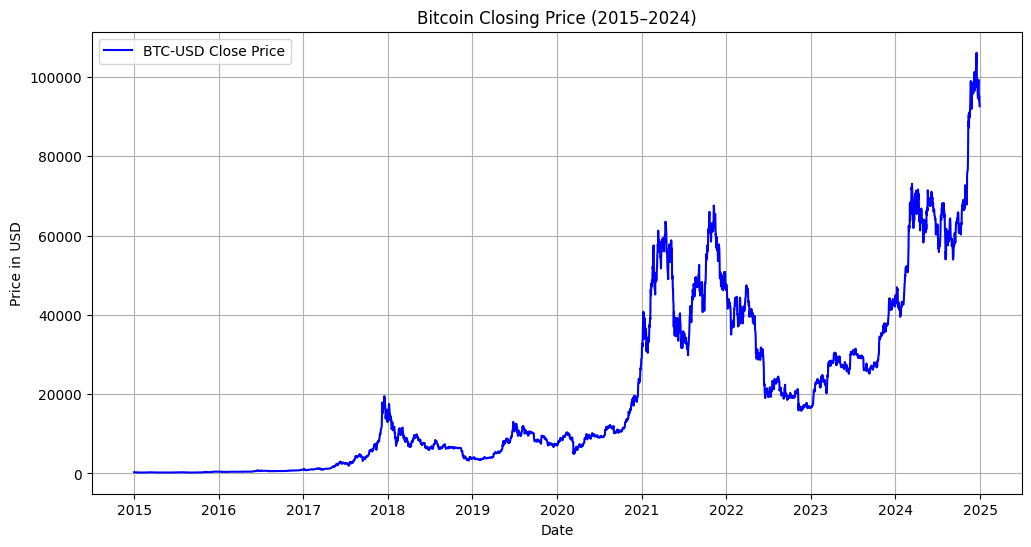

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Fetch Bitcoin data
btc = yf.download('BTC-USD', start='2015-01-01', end='2024-12-31')
btc = btc[['Close']]  # Focus on closing price
btc.dropna(inplace=True)

# Visualize BTC price
plt.figure(figsize=(12,6))
plt.plot(btc['Close'], color='blue', label='BTC-USD Close Price')
plt.title('Bitcoin Closing Price (2015–2024)')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.grid(True)
plt.legend()
plt.show()


In [3]:
# Fetch full BTC data
btc = yf.download('BTC-USD', start='2015-01-01', end='2024-12-31')
btc.dropna(inplace=True)

# Feature Engineering
btc['Daily_Return'] = btc['Close'].pct_change()
btc['Rolling_Mean_7'] = btc['Close'].rolling(window=7).mean()
btc['Rolling_Mean_30'] = btc['Close'].rolling(window=30).mean()
btc['Volatility_7'] = btc['Close'].rolling(window=7).std()
btc['Volatility_30'] = btc['Close'].rolling(window=30).std()
btc.dropna(inplace=True)

# Keep a copy for ARIMA
btc_arima = btc[['Close']].copy()

# Quick check
print(btc.tail())


[*********************100%***********************]  1 of 1 completed

Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2024-12-26  95795.515625  99884.570312  95137.882812  99297.695312   
2024-12-27  94164.859375  97294.843750  93310.742188  95704.976562   
2024-12-28  95163.929688  95525.898438  94014.289062  94160.187500   
2024-12-29  93530.226562  95174.875000  92881.789062  95174.054688   
2024-12-30  92643.210938  94903.320312  91317.132812  93527.195312   

Price            Volume Daily_Return Rolling_Mean_7 Rolling_Mean_30  \
Ticker          BTC-USD                                               
Date                                                                  
2024-12-26  47054980873    -0.035284   96934.662946    98727.185156   
2024-12-27  52419934565    -0.017022   96421.652902    98667.262760   
2024-12-28  24107436185     0.010610   96127.253348    98650.978125   
2024-12-29  2

In [ ]:
from statsmodels.tsa.stattools import adfuller
# stationary check 
# Run Augmented Dickey-Fuller test
result = adfuller(btc_arima['Close'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Rule of thumb: p-value < 0.05 = stationary


ADF Statistic: -0.07696741567076172
p-value: 0.951684890702571


ADF Statistic (Differenced): -8.80246471366871
p-value (Differenced): 2.0942914927267857e-14


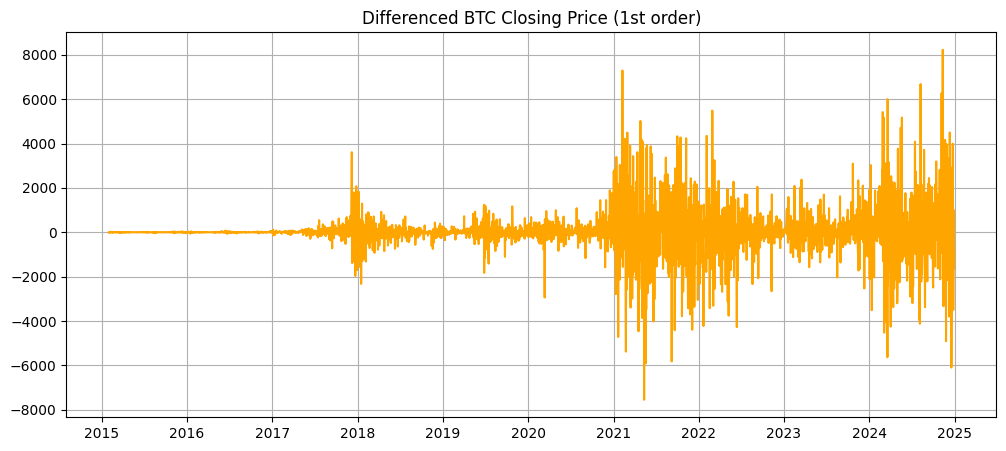

In [5]:
btc_diff = btc_arima['Close'].diff().dropna()

# Check stationarity again
from statsmodels.tsa.stattools import adfuller
result_diff = adfuller(btc_diff)
print("ADF Statistic (Differenced):", result_diff[0])
print("p-value (Differenced):", result_diff[1])

# Plot the differenced series
plt.figure(figsize=(12, 5))
plt.plot(btc_diff, color='orange')
plt.title('Differenced BTC Closing Price (1st order)')
plt.grid()
plt.show()


In [31]:
from statsmodels.tsa.arima.model import ARIMA

# Refit ARIMA model if not already
arima_model = ARIMA(btc_arima[('Close', 'BTC-USD')], order=(5, 1, 2))
arima_result = arima_model.fit()

# Forecast next 30 days
arima_forecast = arima_result.forecast(steps=30)


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


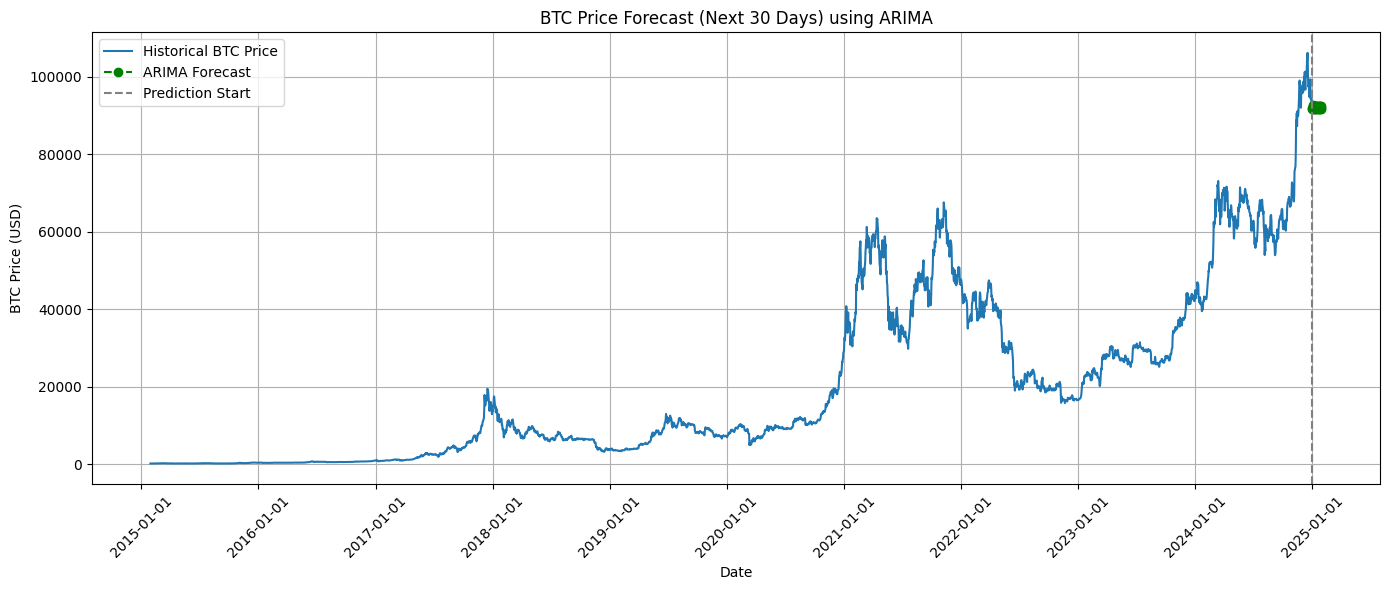

In [ ]:

# Prepare dates for prediction
last_date = btc_arima.index[-1]
future_dates_arima = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(btc_arima.index, btc_arima[('Close', 'BTC-USD')], label='Historical BTC Price')
plt.plot(future_dates_arima, arima_forecast, color='green', marker='o', linestyle='--', label='ARIMA Forecast')

plt.axvline(x=last_date, color='gray', linestyle='--', label='Prediction Start')
plt.title('BTC Price Forecast (Next 30 Days) using ARIMA')
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [36]:
arima_df = pd.DataFrame({
    "Date": future_dates_arima,
    "ARIMA_Predicted_Price": arima_forecast
})
arima_df.to_csv("btc_arima_30day_forecast.csv", index=False)
print("✅ ARIMA forecast saved to btc_arima_30day_forecast.csv")


✅ ARIMA forecast saved to btc_arima_30day_forecast.csv


In [8]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Use 'Close' price only for now
lstm_data = btc_arima[['Close']].copy()

# Scale data between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(lstm_data)

# Function to create sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Create sequences
seq_len = 60
X, y = create_sequences(scaled_data, seq_len)

# Reshape input for LSTM: (samples, timesteps, features)
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (3563, 60, 1)
y shape: (3563, 1)


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Predict next close price

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(X, y, epochs=25, batch_size=32, validation_split=0.1)


c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.0053 - val_loss: 0.0034
Epoch 2/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 8.1276e-04 - val_loss: 0.0016
Epoch 3/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 5.7101e-04 - val_loss: 0.0011
Epoch 4/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - loss: 5.5434e-04 - val_loss: 0.0033
Epoch 5/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 5.8846e-04 - val_loss: 0.0012
Epoch 6/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 4.7650e-04 - val_loss: 0.0014
Epoch 7/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 4.4030e-04 - val_loss: 0.0035
Epoch 8/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - loss: 3.7368e-04 - val_loss: 8.2961e-04
Epoch 9/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 4.8015e-04 - val_loss: 0.0013
Epoch 10/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - loss: 3.7066e-04 - val_loss: 0.0021
Epoch 11/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 3.4102e-04 - val_loss: 0.0

In [43]:
def lstm_forecast(n_days, model, scaled_data, scaler):
    ...

def arima_forecast_func(n_days, close_series):
    ...


In [10]:
# Last 60 values for prediction input
last_60_days = scaled_data[-60:]

# Reshape for LSTM: (1 sample, 60 time steps, 1 feature)
last_60_days = np.reshape(last_60_days, (1, 60, 1))

# Predict
predicted_price_scaled = model.predict(last_60_days)

# Inverse transform to get actual BTC price
predicted_price = scaler.inverse_transform(predicted_price_scaled)

print("🔮 Predicted Next-Day BTC Price:", predicted_price[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
🔮 Predicted Next-Day BTC Price: 92126.375


In [ ]:
print("Predicted price:", predicted_price)
print("Type:", type(predicted_price))
print("Shape:", predicted_price.shape)


Predicted price: [[92126.375]]
Type: <class 'numpy.ndarray'>
Shape: (1, 1)


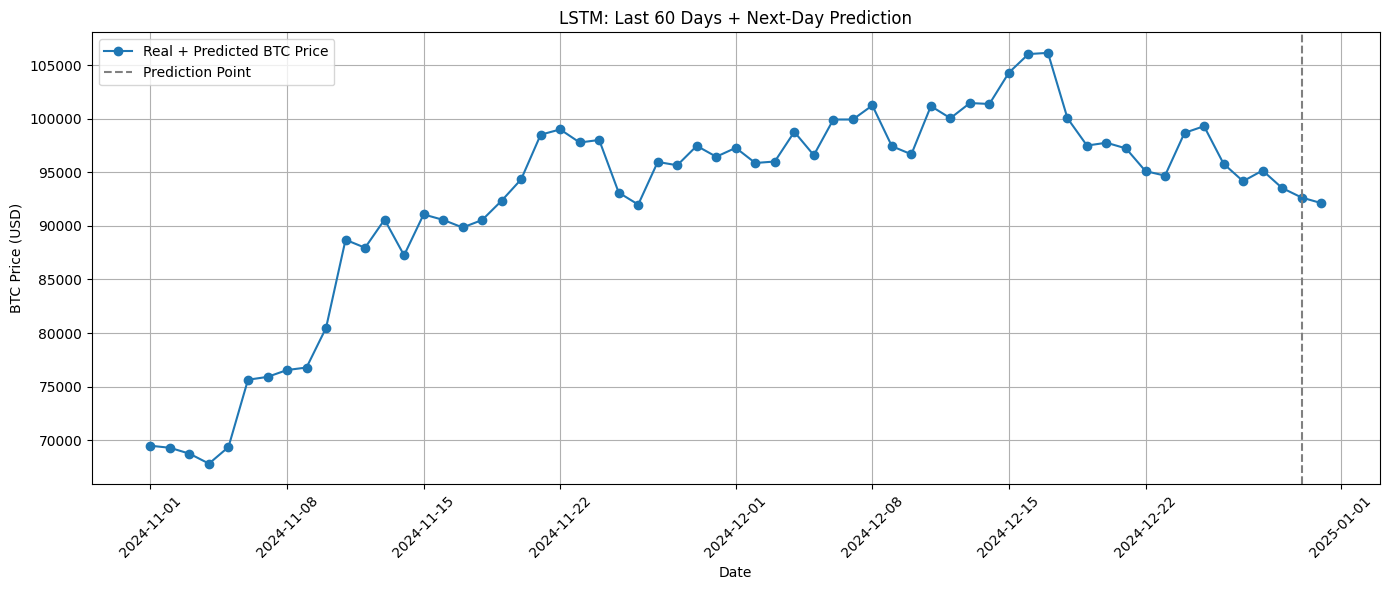

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

# ✅ Extract last 60 closing prices correctly
real_prices = btc_arima[('Close', 'BTC-USD')][-60:].values.flatten().tolist()

# ✅ Flatten the predicted price and append it
predicted_val = float(predicted_price.ravel()[0])
real_prices.append(predicted_val)

# ✅ Prepare corresponding dates
dates = btc_arima.index[-60:].tolist()
future_date = pd.date_range(start=dates[-1] + pd.Timedelta(days=1), periods=1)
dates.append(future_date[0])

# ✅ Convert dates to datetime
dates = pd.to_datetime(dates)

# ✅ Plot
plt.figure(figsize=(14, 6))
plt.plot(dates, real_prices, marker='o', label='Real + Predicted BTC Price')
plt.axvline(x=dates[-2], color='gray', linestyle='--', label='Prediction Point')
plt.title('LSTM: Last 60 Days + Next-Day Prediction')
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

n_days = 30  # You can adjust later

# Use the last 60 values as seed input
input_seq = scaled_data[-60:].reshape(1, 60, 1)
future_scaled = []

for _ in range(n_days):
    next_pred = model.predict(input_seq, verbose=0)[0][0]
    future_scaled.append(next_pred)

    # Shift + append new value
    new_input = np.append(input_seq[0, 1:, 0], next_pred)
    input_seq = new_input.reshape(1, 60, 1)

# Inverse transform predicted values
future_predictions_actual = scaler.inverse_transform(np.array(future_scaled).reshape(-1, 1)).flatten()


In [26]:
# Get last real closing prices
last_real_prices = btc_arima[('Close', 'BTC-USD')][-60:].values.flatten()
last_dates = btc_arima.index[-60:]

# Prepare future dates
last_date = last_dates[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_days)

# Optional: combine for saving
pred_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted_BTC_Close": future_predictions_actual
})


In [ ]:
# Step 1A: LSTM Forecast Function
def lstm_forecast(n_days, model, scaled_data, scaler):
    input_seq = scaled_data[-60:].reshape(1, 60, 1)
    future_scaled = []

    for _ in range(n_days):
        next_pred = model.predict(input_seq, verbose=0)[0][0]
        future_scaled.append(next_pred)
        new_input = np.append(input_seq[0, 1:, 0], next_pred)
        input_seq = new_input.reshape(1, 60, 1)

    return scaler.inverse_transform(np.array(future_scaled).reshape(-1, 1)).flatten()


In [38]:
# 🔁 LSTM Multi-day Forecast Function
def lstm_forecast(n_days, model, scaled_data, scaler):
    input_seq = scaled_data[-60:].reshape(1, 60, 1)
    future_scaled = []

    for _ in range(n_days):
        next_pred = model.predict(input_seq, verbose=0)[0][0]
        future_scaled.append(next_pred)
        new_input = np.append(input_seq[0, 1:, 0], next_pred)
        input_seq = new_input.reshape(1, 60, 1)

    return scaler.inverse_transform(np.array(future_scaled).reshape(-1, 1)).flatten()


In [39]:
# 🔁 ARIMA Multi-day Forecast Function
def arima_forecast_func(n_days, close_series):
    arima_model = ARIMA(close_series, order=(5, 1, 2))
    arima_result = arima_model.fit()
    return arima_result.forecast(steps=n_days)


In [40]:
n_days = 3  # or 1 to 7, based on what you want to test

# Forecasts
lstm_preds = lstm_forecast(n_days, model, scaled_data, scaler)
arima_preds = arima_forecast_func(n_days, btc_arima[('Close', 'BTC-USD')])


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


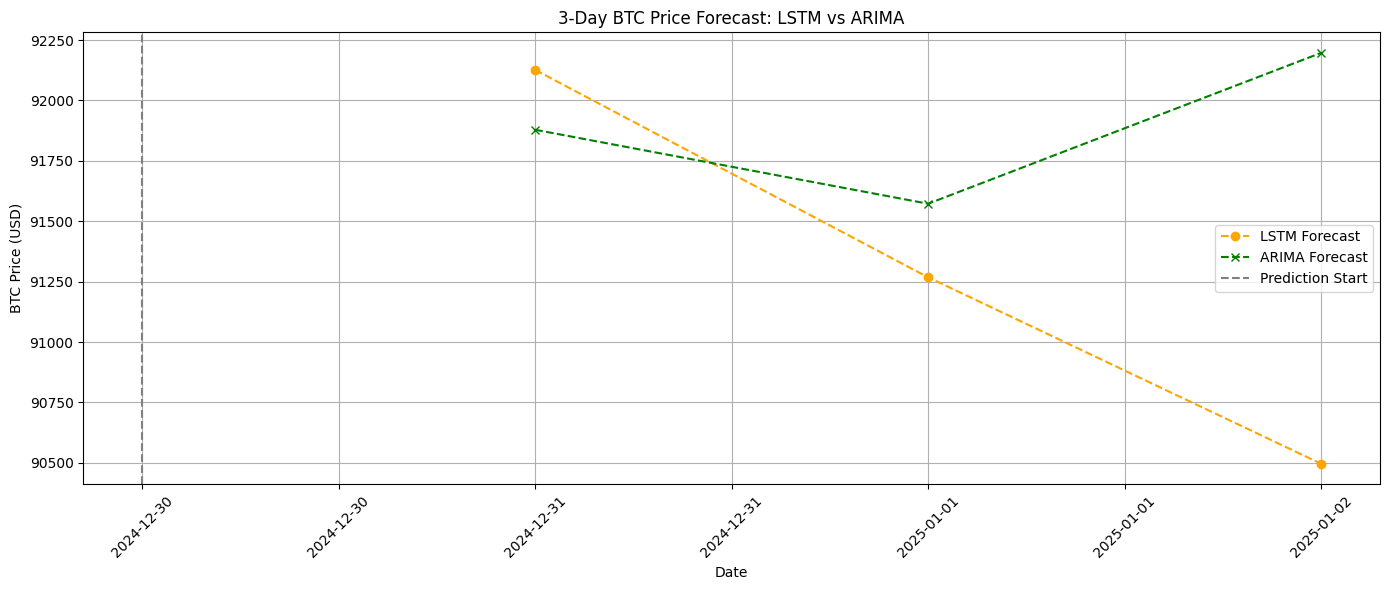

In [41]:
# Create future date range
future_dates = pd.date_range(start=btc_arima.index[-1] + pd.Timedelta(days=1), periods=n_days)

# Plot LSTM & ARIMA
plt.figure(figsize=(14, 6))
plt.plot(future_dates, lstm_preds, marker='o', linestyle='--', label='LSTM Forecast', color='orange')
plt.plot(future_dates, arima_preds, marker='x', linestyle='--', label='ARIMA Forecast', color='green')
plt.axvline(x=btc_arima.index[-1], color='gray', linestyle='--', label='Prediction Start')

plt.title(f'{n_days}-Day BTC Price Forecast: LSTM vs ARIMA')
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
# Insight Message Function
def interpret_trend(change, model_name):
    if change > 5:
        return f"📈 {model_name} predicts BTC may rise by {change:.2f}% — Consider Buying."
    elif change < -5:
        return f"📉 {model_name} predicts BTC may drop by {abs(change):.2f}% — Consider Selling."
    else:
        return f"📊 {model_name} predicts stable BTC price ({change:.2f}%)."

# % Change Calculations
lstm_change = ((lstm_preds[-1] - lstm_preds[0]) / lstm_preds[0]) * 100
arima_change = ((arima_preds.iloc[-1] - arima_preds.iloc[0]) / arima_preds.iloc[0]) * 100

# Print Insights
print("🧠 Forecast Insights for Next", n_days, "Days:")
print(interpret_trend(lstm_change, "LSTM"))
print(interpret_trend(arima_change, "ARIMA"))


🧠 Forecast Insights for Next 3 Days:
📊 LSTM predicts stable BTC price (-1.77%).
📊 ARIMA predicts stable BTC price (0.35%).


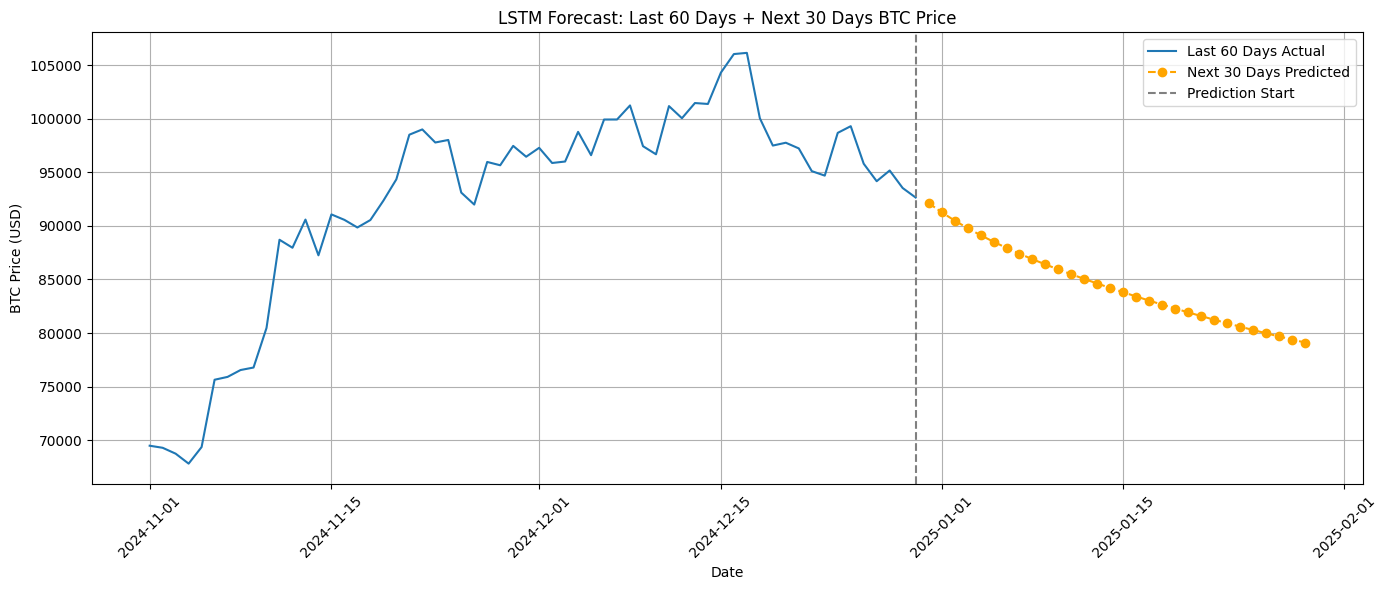

In [27]:
# Plot
plt.figure(figsize=(14, 6))
plt.plot(last_dates, last_real_prices, label='Last 60 Days Actual')
plt.plot(future_dates, future_predictions_actual, color='orange', marker='o', linestyle='--', label='Next 30 Days Predicted')

plt.axvline(x=last_date, color='gray', linestyle='--', label='Prediction Start')
plt.title('LSTM Forecast: Last 60 Days + Next 30 Days BTC Price')
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
pred_df.to_csv("btc_lstm_30day_forecast.csv", index=False)
print("✅ 30-day forecast saved to btc_lstm_30day_forecast.csv")


✅ 30-day forecast saved to btc_lstm_30day_forecast.csv


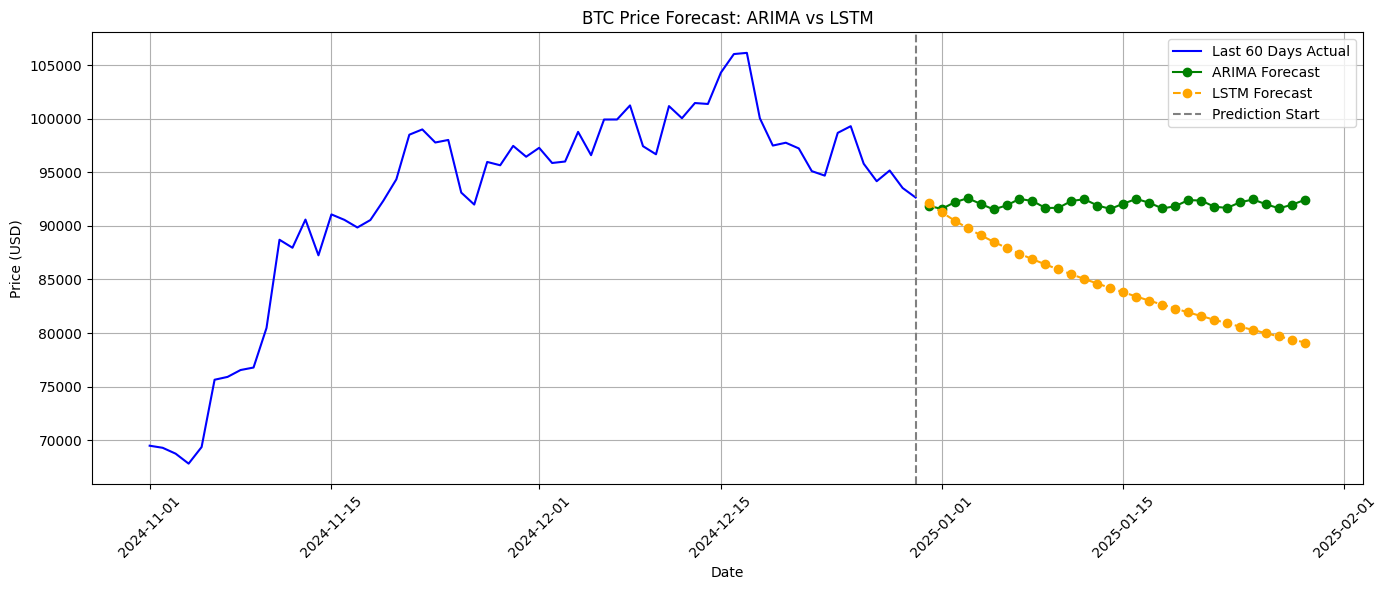

In [34]:
# Just to be safe, convert ARIMA forecast to flat list if needed
arima_forecast_flat = np.array(arima_forecast).flatten()  # If not already

# Create the comparison plot
plt.figure(figsize=(14, 6))

# Plot actual BTC close prices for the last 60 days
plt.plot(btc_arima.index[-60:], btc_arima[('Close', 'BTC-USD')][-60:], label='Last 60 Days Actual', color='blue')

# Plot ARIMA forecast
plt.plot(future_dates, arima_forecast_flat, color='green', marker='o', linestyle='-', label='ARIMA Forecast')

# Plot LSTM forecast
plt.plot(future_dates, future_predictions_actual, color='orange', marker='o', linestyle='--', label='LSTM Forecast')

# Formatting
plt.axvline(x=btc_arima.index[-1], color='gray', linestyle='--', label='Prediction Start')
plt.title('BTC Price Forecast: ARIMA vs LSTM')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:
# LSTM trend
lstm_start = future_predictions_actual[0]
lstm_end = future_predictions_actual[-1]
lstm_change = ((lstm_end - lstm_start) / lstm_start) * 100

# ARIMA trend
arima_start = arima_forecast.iloc[0]
arima_end = arima_forecast.iloc[-1]
arima_change = ((arima_end - arima_start) / arima_start) * 100

# Format messages
def interpret_trend(change, model_name):
    if change > 5:
        return f"📈 {model_name} predicts a significant **increase** of {change:.2f}% in BTC price over the next 30 days."
    elif change < -5:
        return f"📉 {model_name} predicts a significant **decrease** of {abs(change):.2f}% in BTC price over the next 30 days."
    elif -5 <= change <= 5:
        return f"📊 {model_name} predicts **minor changes** ({change:.2f}%) — BTC is likely to remain stable."
    
# Print messages
print(interpret_trend(lstm_change, "LSTM"))
print(interpret_trend(arima_change, "ARIMA"))

# 🔍 Emoji-based Recommendation System
def make_recommendation(change):
    if change > 5:
        return "🟢 Recommendation: **BUY** (Uptrend expected)"
    elif change < -5:
        return "🔴 Recommendation: **SELL** (Downtrend expected)"
    else:
        return "🟡 Recommendation: **HOLD** (Stable trend)"

# Show Recommendations
print("\n💡 Actionable Recommendations:")
print("LSTM:", make_recommendation(lstm_change))
print("ARIMA:", make_recommendation(arima_change))



📉 LSTM predicts a significant **decrease** of 14.13% in BTC price over the next 30 days.
📊 ARIMA predicts **minor changes** (0.60%) — BTC is likely to remain stable.

💡 Actionable Recommendations:
LSTM: 🔴 Recommendation: **SELL** (Downtrend expected)
ARIMA: 🟡 Recommendation: **HOLD** (Stable trend)
